In [2]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

# Import filter function
from neurodsp.filt import filter_signal

# Import simulation code for creating test data
from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed, create_times

# Import utilities for loading and plotting data
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.time_series import plot_time_series

from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats

# Import simulation code for creating test data
from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed, create_times

# Import utilities for loading and plotting data
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.time_series import plot_time_series, plot_bursts

In [3]:
def baseline_wavelets(tmin, tmax, average_mwts):
    ''' This takes the average and standard deviation from tmin to tmax and divides
        by the sd and subtracts the mean to baseline the signal
    '''
    # get average and standard deviation
    average_pretrial = np.nanmean(average_mwts[:, tmin:tmax])
    sd_pretrial = np.nanstd(average_mwts[:, tmin:tmax])
    
    # perform baseline
    baselined_average_mwts = (average_mwts - average_pretrial)/sd_pretrial
    
    return(baselined_average_mwts)


In [4]:
## Prep paths ##

subject = 'BJH016'
orig_data_fi = '/home/brooke/knight_server/remote/WashU/data/PacmanTask/BJH016/PacmanTask/ECOGS001R01.dat'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [4]:
## Load Behavioral Data ##
behavioral_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_processed_behave.csv")
behavioral_data


subject  Trial  trial_numeric  trial_in_block  TrialType  trial_died  \
0    BJH016      1              1               1          5           0   
1    BJH016      2              2               2          8           1   
2    BJH016      3              3               3         11           1   
3    BJH016      4              4               4          3           0   
4    BJH016      5              5               5         10           1   
..      ...    ...            ...             ...        ...         ...   
447  BJH016    448            448               8         18           0   
448  BJH016    449            449               9         19           1   
449  BJH016    450            450              10         13           1   
450  BJH016    451            451              11          5           0   
451  BJH016    452            452              12          1           0   

     last_trial_in_minigame  Lives  dots_eaten  max_trial  ...  average_score  \
0                         0      3           0        452  ...     321.177458   
1                         0      3           5        452  ...     321.177458   
2                         0      2           5        452  ...     321.177458   
3                         0      1           0        452  ...     321.177458   
4                         1      1           5        452  ...     321.177458   
..                      ...    ...         ...        ...  ...            ...   
447                       0      1           5        452  ...     321.177458   
448                       1      1           5        452  ...     321.177458   
449                       0      3           5        452  ...     321.177458   
450                       0      2           0        452  ...     321.177458   
451                       0      1           0        452  ...     321.177458   

     max_time  trial_in_minigame  minigame  longest_minigame  \
0     2937.75                  1         1                19   
1     2937.75                  2         1                19   
2     2937.75                  3         1                19   
3     2937.75                  4         1                19   
4     2937.75                  5         1                19   
..        ...                ...       ...               ...   
447   2937.75                  8        64                19   
448   2937.75                  9        64                19   
449   2937.75                  1        65                19   
450   2937.75                  2        65                19   
451   2937.75                  3        65                19   

     longest_minigame_under20  number_of_minigames  block  block_deaths  \
0                          19                   65      1            14   
1                          19                   65      1            14   
2                          19                   65      1            14   
3                          19                   65      1            14   
4                          19                   65      1            14   
..                        ...                  ...    ...           ...   
447                        19                   65     23             3   
448                        19                   65     23             3   
449                        19                   65     23             3   
450                        19                   65     23             3   
451                        19                   65     23             3   

     average_dots_per_block  
0                      3.35  
1                      3.35  
2                      3.35  
3                      3.35  
4                      3.35  
..                      ...  
447                    3.75  
448                    3.75  
449                    3.75  
450                    3.75  
451                    3.75  

[452 rows x 21 columns]

In [5]:
## Load Neural Data

# load
epoched_data = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean.fif")
trial_lengths = np.load(f"{preproc_data_dir}/{subject}_trial_lengths.npy")

# get good epochs
good_epochs = [i for i,x in enumerate(epoched_data.get_annotations_per_epoch()) if not x]

# pull out the neural data
epoch_df = epoched_data.get_data()

Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean.fif ...


/tmp/ipykernel_3151/1077797833.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean.fif")


    Found the data of interest:
        t =   -1750.00 ...   14750.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean-1.fif ...
    Found the data of interest:
        t =   -1750.00 ...   14750.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean-2.fif ...
    Found the data of interest:
        t =   -1750.00 ...   14750.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean-3.fif ...
    Found the data of interest:
        t =   -1750.00 ...   14750.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_clean-4.fif ...
    Found the data of interest:
        t =   -1750.00 ...   14750.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH016/ieeg/BJH016_bp_raw_c

In [11]:
epoch_df.shape

2000*(14.75 + 1.75)

33000.0

In [7]:
# Only take good epochs

behavioral_data['Trial'] = behavioral_data['Trial'] - 1
clean_behave_data = behavioral_data[behavioral_data['Trial'].isin(good_epochs)]
epoch_df = epoch_df[good_epochs, :, :]
usable_trial_lengths = trial_lengths[0][good_epochs]

In [22]:
no_ghost_trials = clean_behave_data['Trial'][clean_behave_data['TrialType'] > 16]

In [8]:
## Dictionary of electrode locations


ROIs = {
    'hc'     :['OR3', 'OR4', 'OR5', 'OR6', 'OR7', 'IL2', 'IL3', 'IL4', 'HL1', 'HL2', 'HL3', 'HL4', 'HL5', 'HL6'],
    'ofc'    :['AL1', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8', 'AL9', 'AL10', 'AL11', 'AL12'],
    'amyg'   :['GL2', 'GL3', 'GL4', 'GL5', 'GL6'],
    'insula' :['BL1', 'BL2', 'BL3', 'BL4', 'BL5',  'BL6', 'BL7', 'BL8', 'BL9', 'LL1', 'LL2', 'LL3', 'LL4'],
    'cing'   :['CL1', 'CL2', 'CL3', 'CL4']
}

hc_list = []
ofc_list = []
amyg_list = []
insula_list = []
cing_list = []
pairs_name = [ch.split('-') for ch in epoched_data.info['ch_names']]

for ix in range(1, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(epoched_data.info['ch_names'][ix])
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(epoched_data.info['ch_names'][ix])
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(epoched_data.info['ch_names'][ix])
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(epoched_data.info['ch_names'][ix])
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(epoched_data.info['ch_names'][ix])   

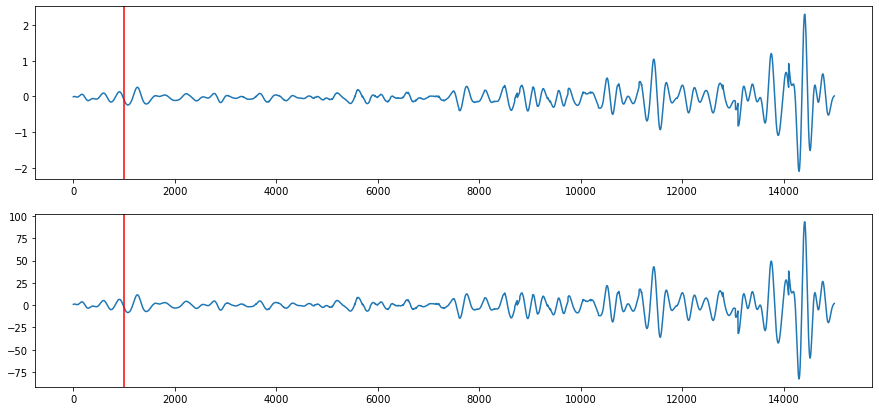

In [23]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

# set up freq bands
fs = 2000
freq_range = (2, 6)
ch = 'HL5-HL6'

# # get the indices of no ghost trials
# clean_behave_data.reset_index(inplace=True, drop = True)
# no_ghost_trials = clean_behave_data.index[clean_behave_data['TrialType'] > 16].tolist()
# ghost_trials = clean_behave_data.index[clean_behave_data['TrialType'] <= 16].tolist()

# sort the trial lengths
longest_idx = np.flip(np.argsort(usable_trial_lengths))

# # Get trial type specific trial lengths
# ghost_trial_lengths = np.delete(longest_idx, no_ghost_trials)
# no_ghost_trial_lengths = np.delete(longest_idx, ghost_trials)



chx = epoched_data.info['ch_names'].index(ch)
theta_list = []

for trial in range(epoch_df.shape[0]): # iterate over trials
    sig = epoch_df[trial, chx, :]
    sig_filt = filter_signal(sig, 2000, 'bandpass', freq_range)
    sig_filt = sig_filt[np.logical_not(np.isnan(sig_filt))]
    sig_filt_dp = signal.decimate(sig_filt, 2)    
    theta_list.append(sig_filt_dp)

theta_data = np.row_stack(theta_list)
# nan out after trial events
na_end = theta_data.shape[1]
for idx in range(theta_data.shape[0]):
    le = np.floor((usable_trial_lengths[idx] + 2000)/2)
    na_begin = int(na_end - le)
    theta_data[idx, int(le):na_end] = np.nan

# baseline the data
baselined_theta = baseline_wavelets(tmin = 500, tmax = 1000, average_mwts = theta_data)

# average across trials
average_baselined_theta = np.nanmean(baselined_theta, axis = 0)
average_theta = np.nanmean(theta_data, axis = 0)

# plot 
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(np.arange(average_baselined_theta.shape[0]), average_baselined_theta)
ax2.plot(np.arange(average_theta.shape[0]), average_theta)
ax1.axvline(x=1000, color = 'red')
ax2.axvline(x=1000, color = 'red')

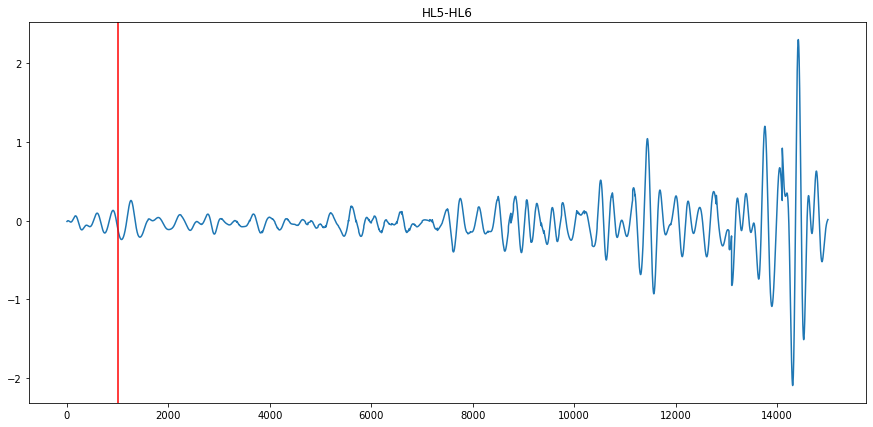

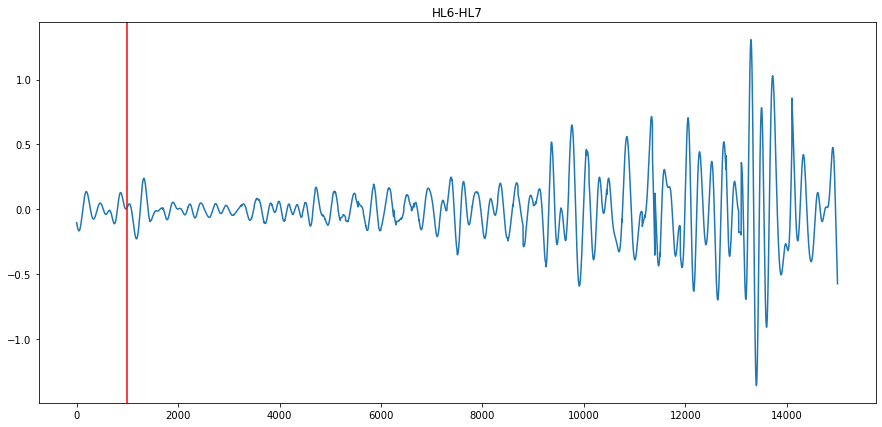

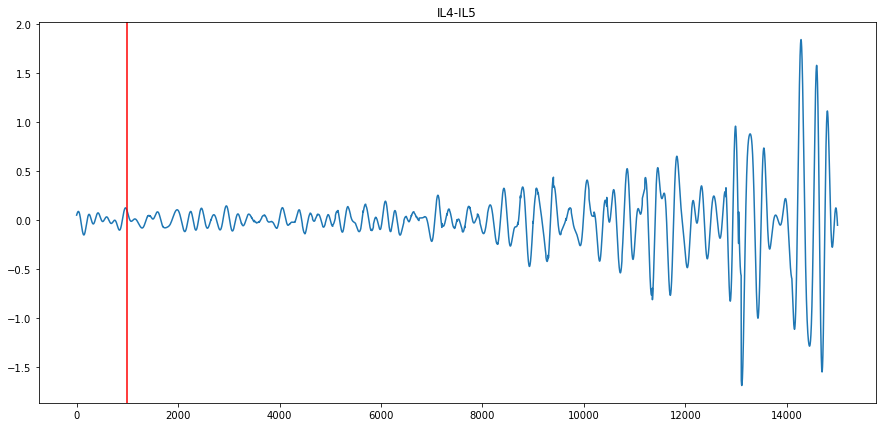

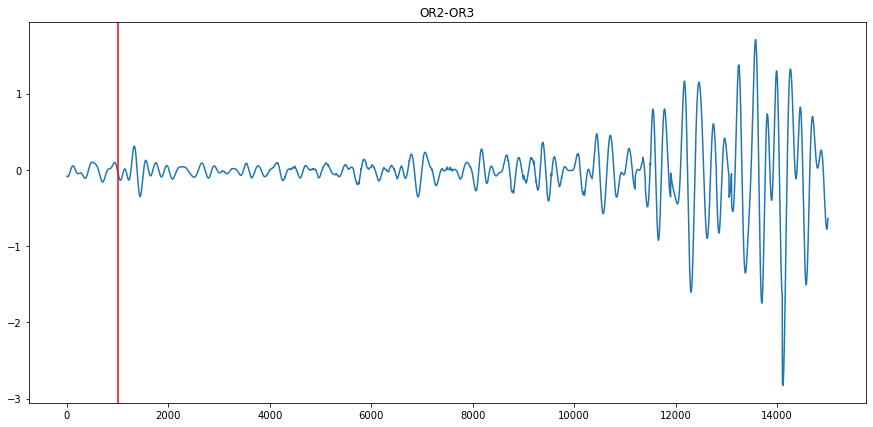

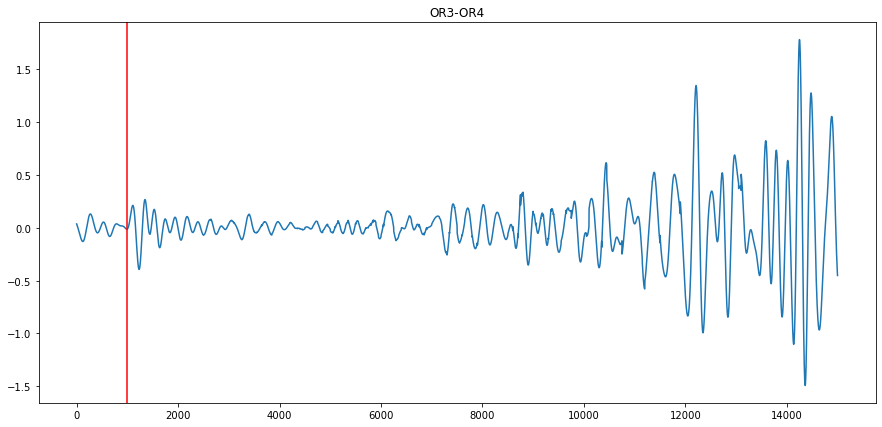

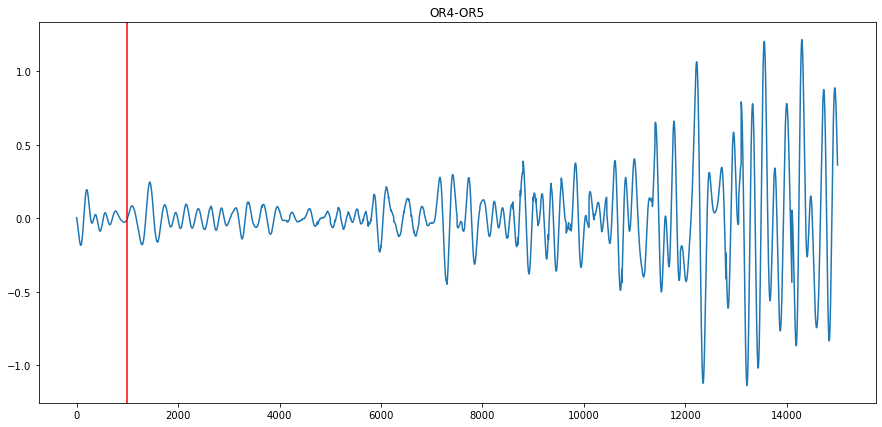

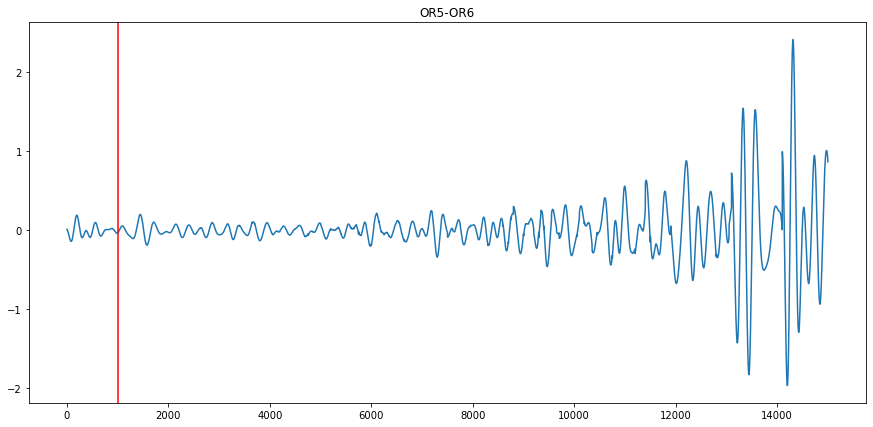

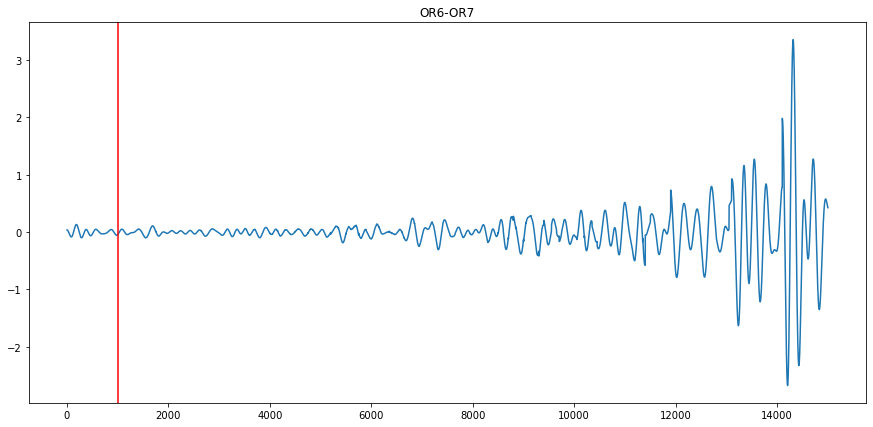

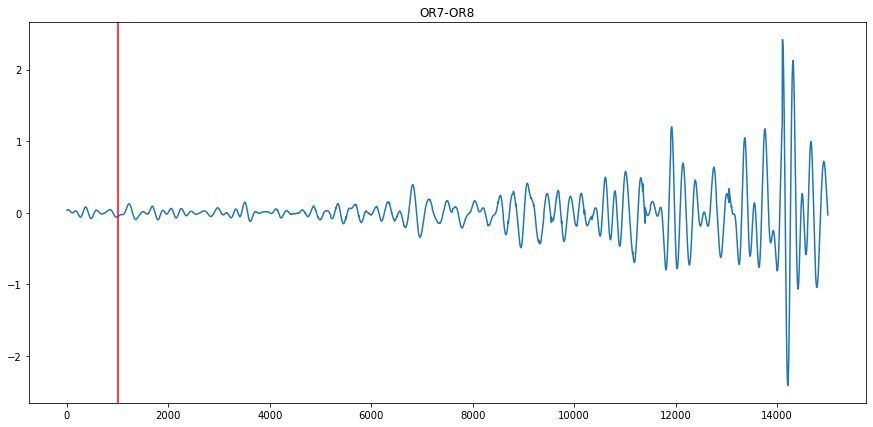

In [16]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

# set up freq bands
fs = 2000
freq_range = (2, 6)


# # get the indices of no ghost trials
# clean_behave_data.reset_index(inplace=True, drop = True)
# no_ghost_trials = clean_behave_data.index[clean_behave_data['TrialType'] > 16].tolist()
# ghost_trials = clean_behave_data.index[clean_behave_data['TrialType'] <= 16].tolist()

# sort the trial lengths
longest_idx = np.flip(np.argsort(usable_trial_lengths))

# # Get trial type specific trial lengths
# ghost_trial_lengths = np.delete(longest_idx, no_ghost_trials)
# no_ghost_trial_lengths = np.delete(longest_idx, ghost_trials)


for ch in hc_list:
    chx = epoched_data.info['ch_names'].index(ch)
    theta_list = []

    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        sig_filt = filter_signal(sig, 2000, 'bandpass', freq_range)
        sig_filt = sig_filt[np.logical_not(np.isnan(sig_filt))]
        sig_filt_dp = signal.decimate(sig_filt, 2)    
        theta_list.append(sig_filt_dp)

    theta_data = np.row_stack(theta_list)
    # nan out after trial events
    na_end = theta_data.shape[1]
    for idx in range(theta_data.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 2000)/2)
        na_begin = int(na_end - le)
        theta_data[idx, int(le):na_end] = np.nan

    # baseline the data
    baselined_theta = baseline_wavelets(tmin = 500, tmax = 1000, average_mwts = theta_data)

    # average across trials
    average_baselined_theta = np.nanmean(baselined_theta, axis = 0)

    # plot the first 6 seconds of trials by ghost vs no ghost
    plt.plot(np.arange(average_baselined_theta.shape[0]), average_baselined_theta)
    plt.axvline(x=1000, color = 'red')
    plt.title(ch)
    plt.show()


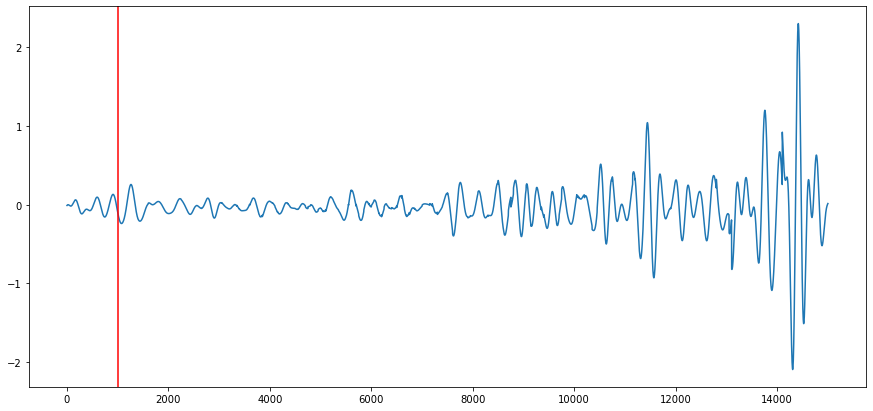

In [15]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]



### Hippocampus

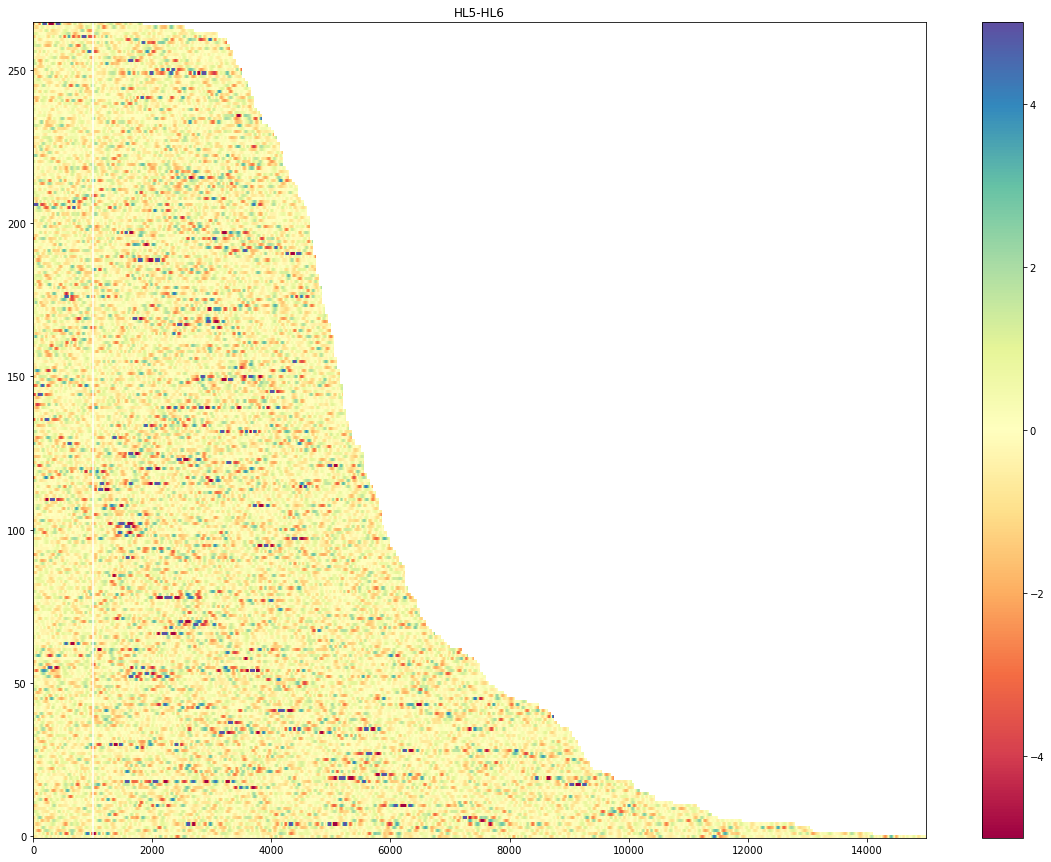

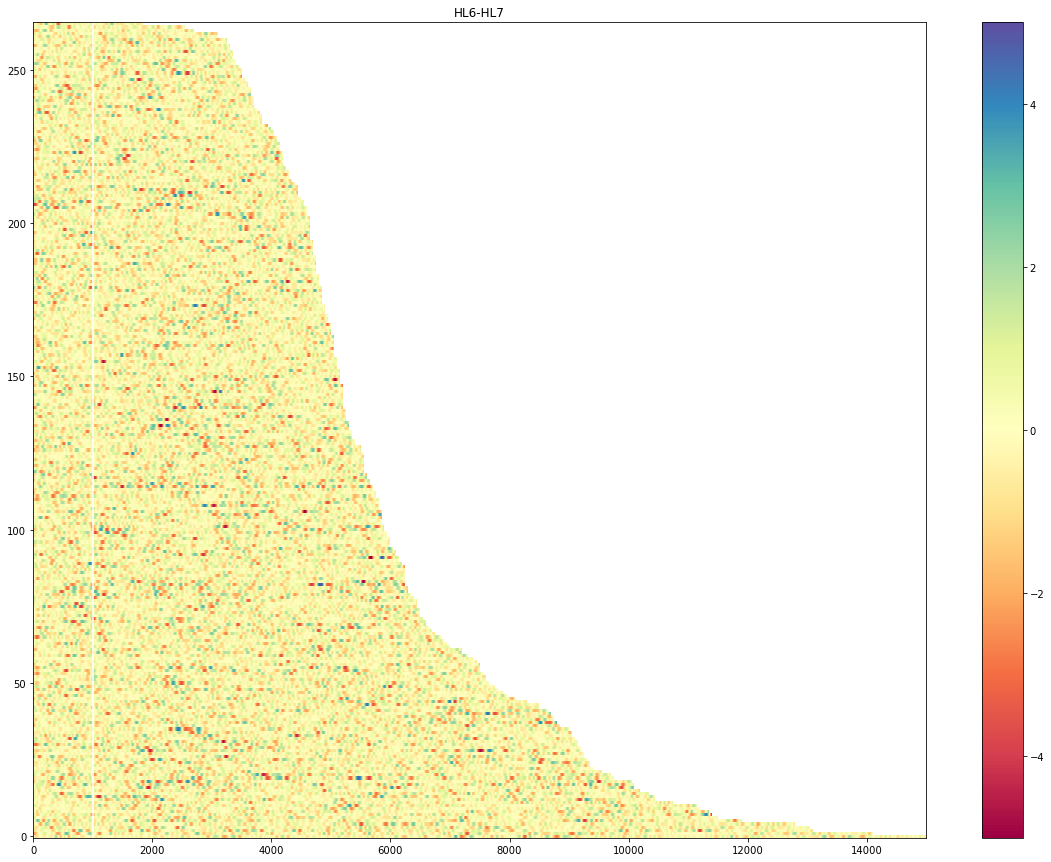

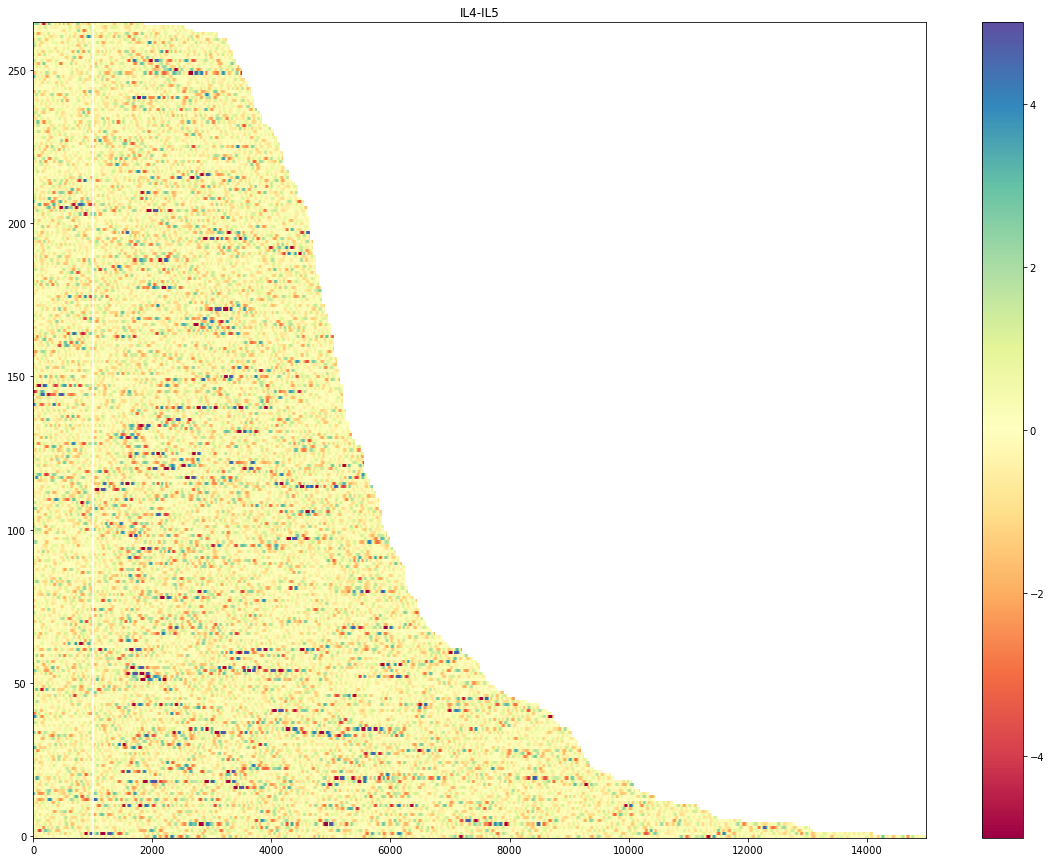

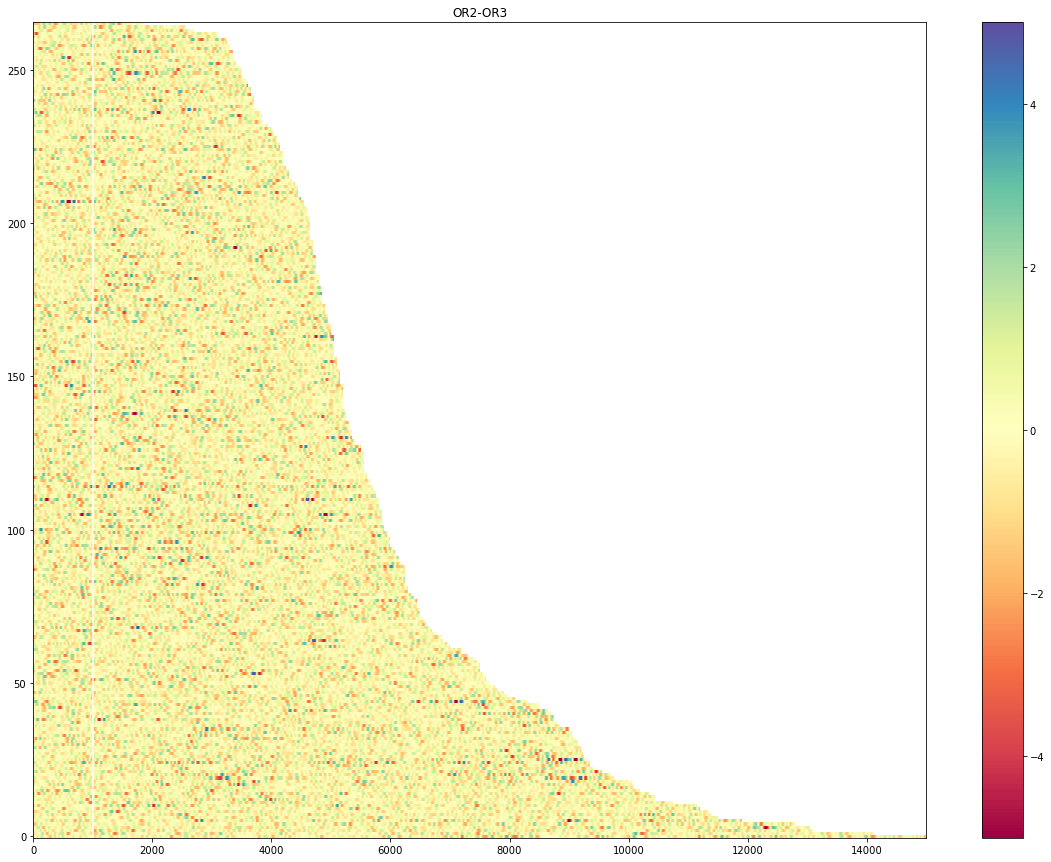

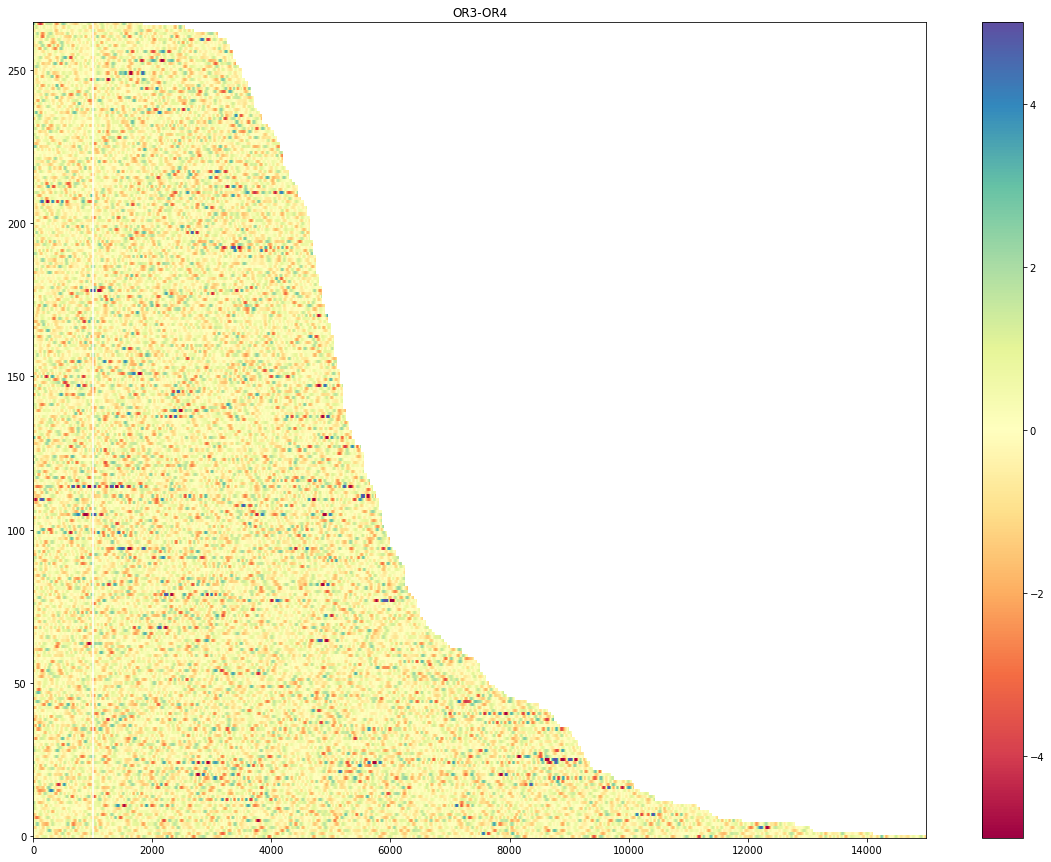

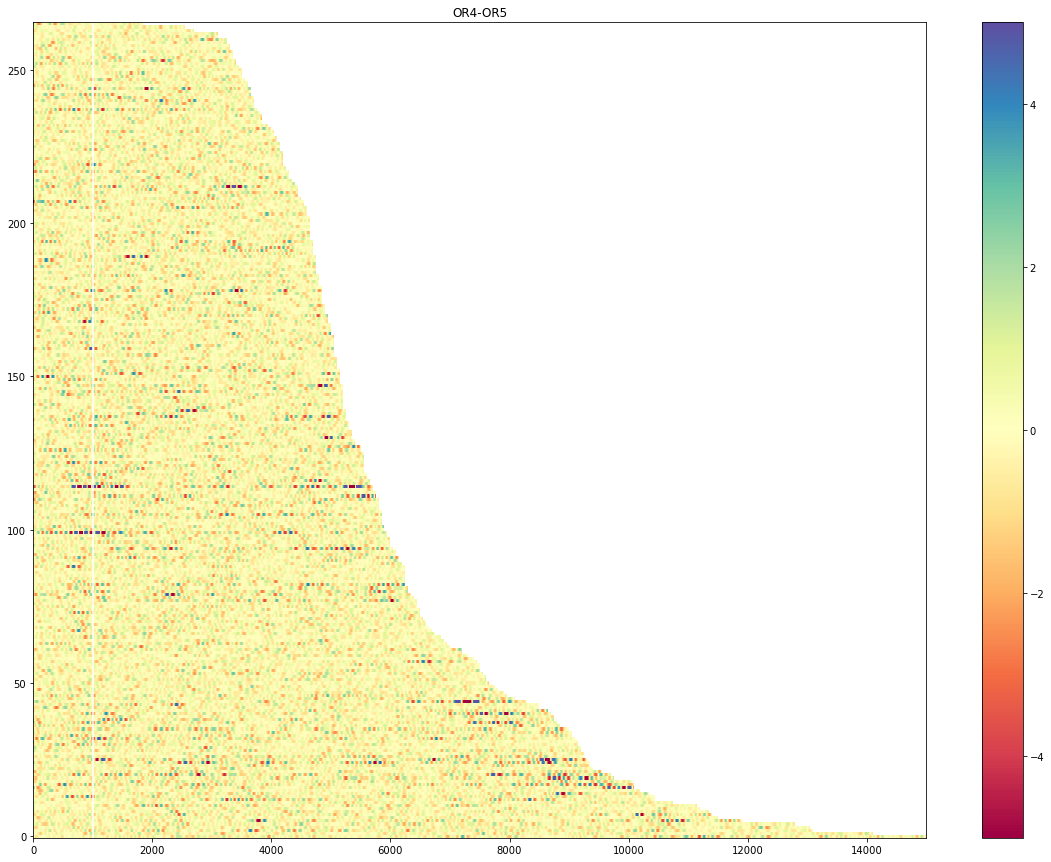

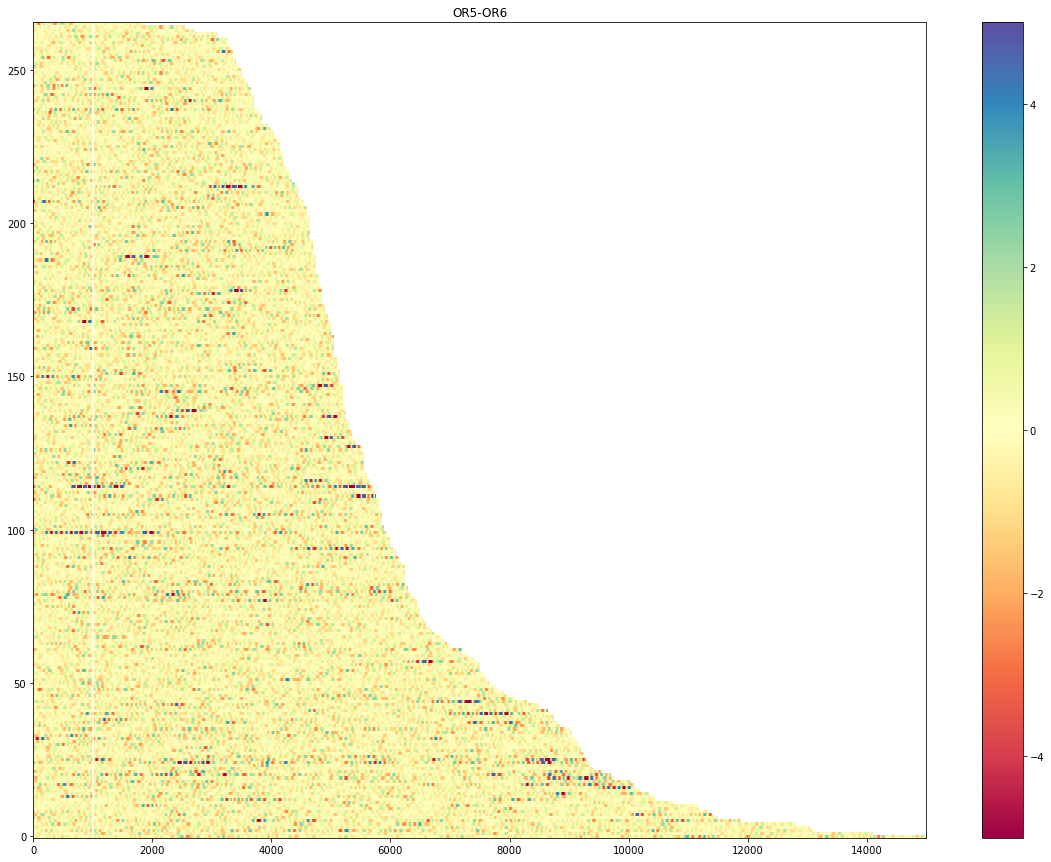

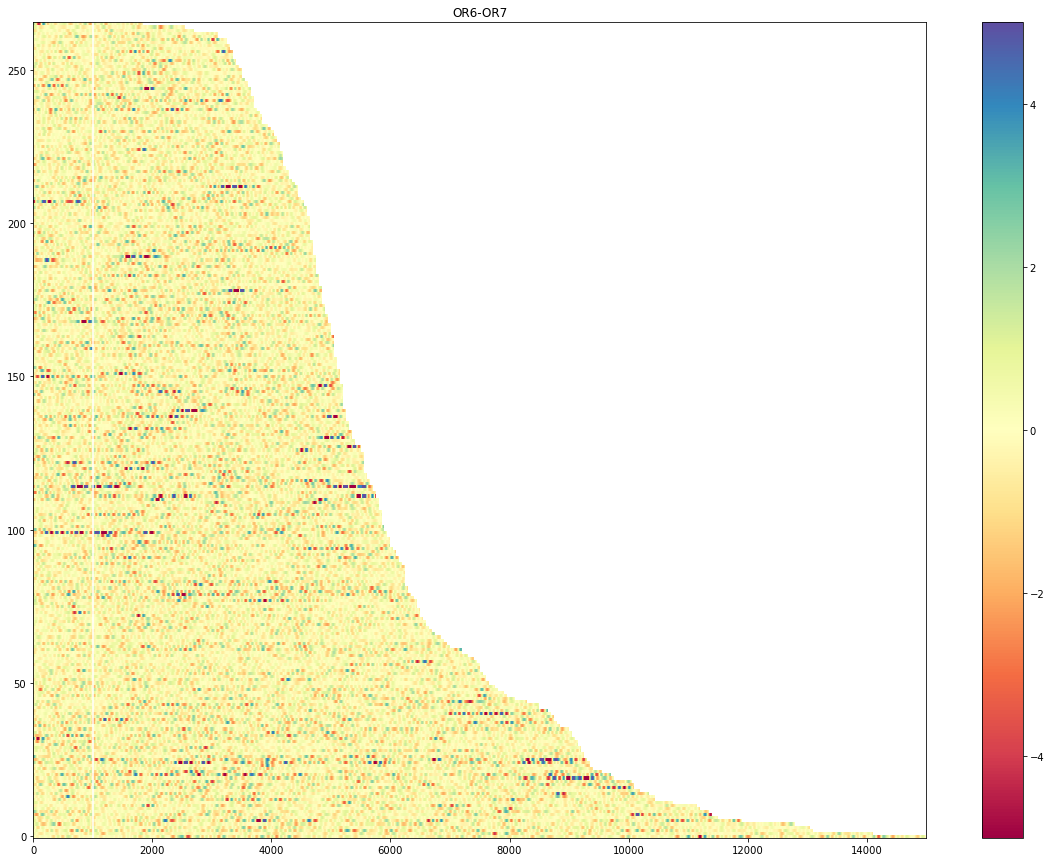

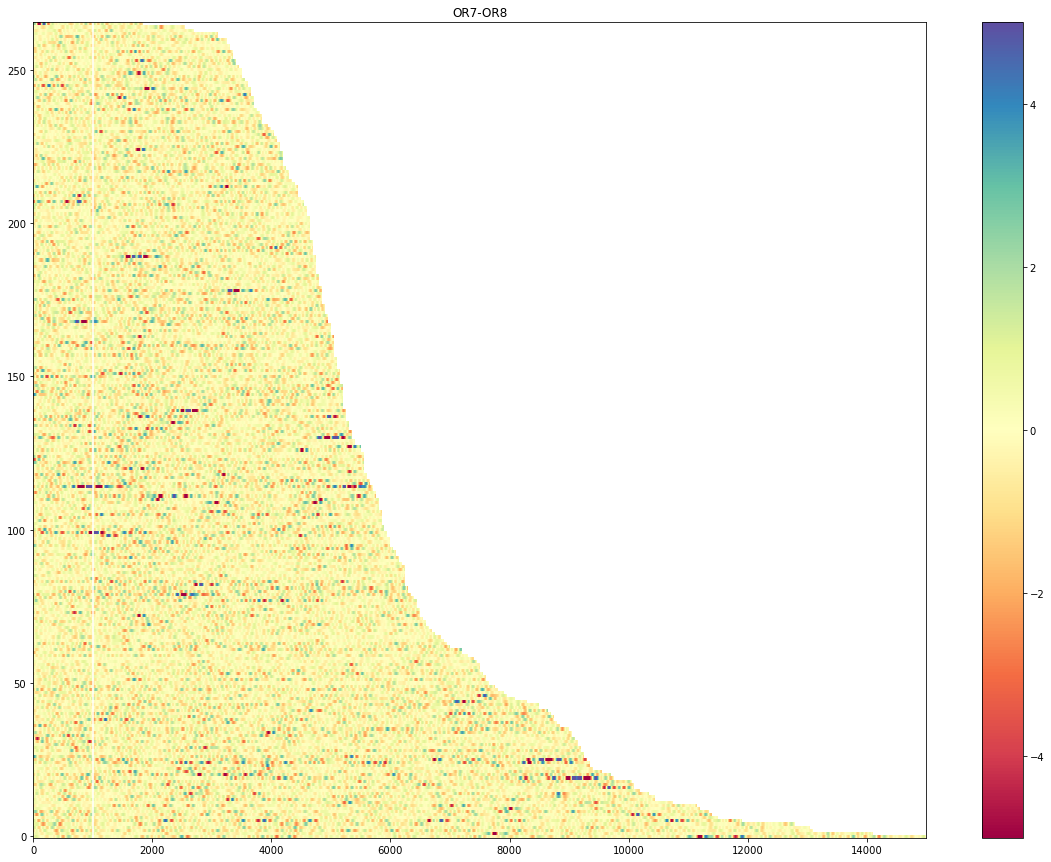

In [18]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = (2, 9)
longest_idx = np.flip(np.argsort(usable_trial_lengths))

for ch in hc_list:
    chx = epoched_data.info['ch_names'].index(ch)
    theta_list = []

    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        sig_filt = filter_signal(sig, 2000, 'bandpass', freq_range)
        sig_filt = sig_filt[np.logical_not(np.isnan(sig_filt))]
        sig_filt_dp = signal.decimate(sig_filt, 2)    
        theta_list.append(sig_filt_dp)
    theta_data = np.row_stack(theta_list)
    
    # nan out after trial events
    na_end = theta_data.shape[1]
    for idx in range(theta_data.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 2000)/2)
        na_begin = int(na_end - le)
        theta_data[idx, int(le):na_end] = np.nan

    # baseline the data
    baselined_theta = baseline_wavelets(tmin = 500, tmax = 1000, average_mwts = theta_data)


    # sort by longest trial
    baselined_theta = baselined_theta[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(baselined_theta.shape[1]), np.arange(baselined_theta.shape[0]), baselined_theta, cmap = 'Spectral', vmin = -5, vmax = 5)
    plt.axvline(x=1000, color = 'white')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    
    

In [16]:
# set up freq bands
fs = 2000
amp_dual_thresh = (1, 2)
f_range = (2, 9)
ch = 'HL5-HL6'
times = create_times(16.5005, fs)

chx = epoched_data.info['ch_names'].index(ch)

bursts = 0
for trial in range(epoch_df.shape[0]): # iterate over trials
    # get single trial
    sig = epoch_df[trial, chx, :]
    # Detect bursts using dual threshold algorithm
    bursting = detect_bursts_dual_threshold(sig, fs, amp_dual_thresh, f_range)
    
    if np.any(bursting):
        bursts = bursts + 1

In [17]:
bursts/epoch_df.shape[0]

0.03383458646616541

/home/brooke/anaconda3/envs/ieeg_analysis/lib/python3.9/site-packages/neurodsp/plts/utils.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=figsize)


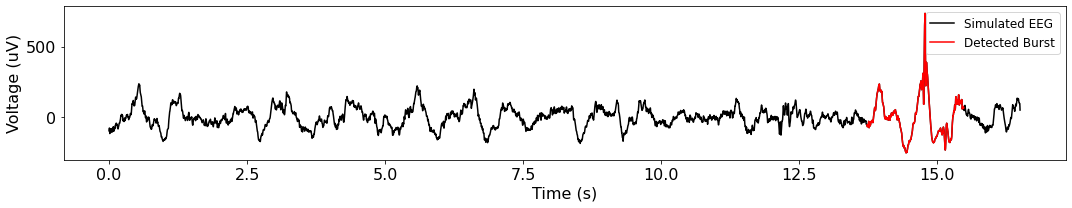

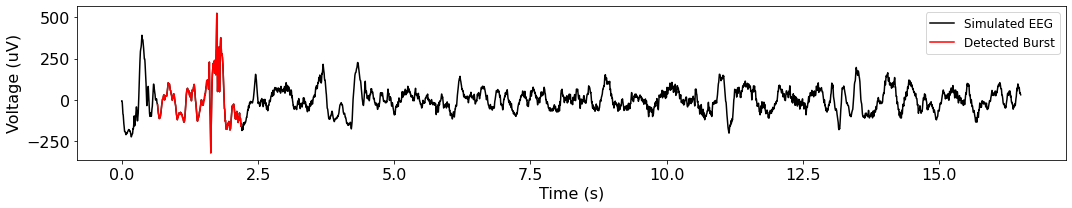

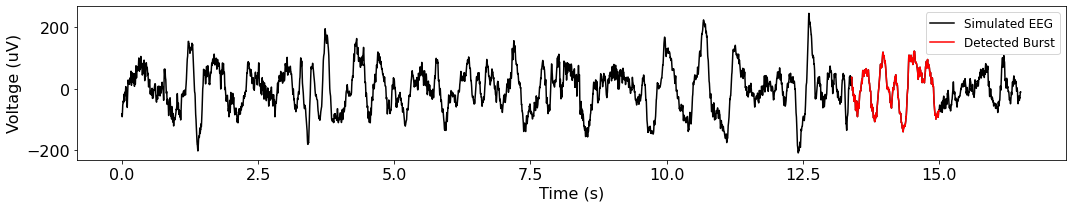

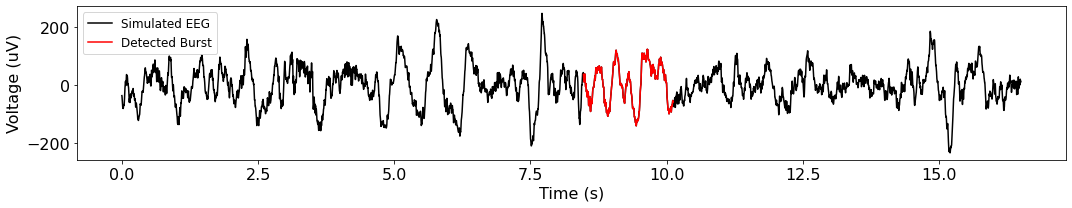

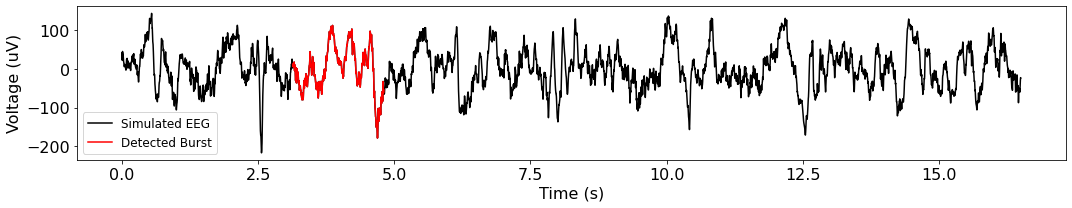

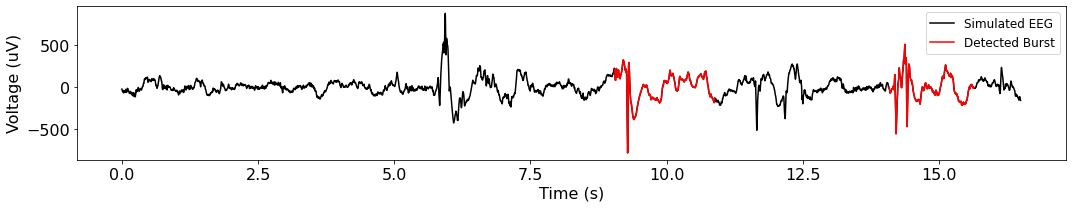

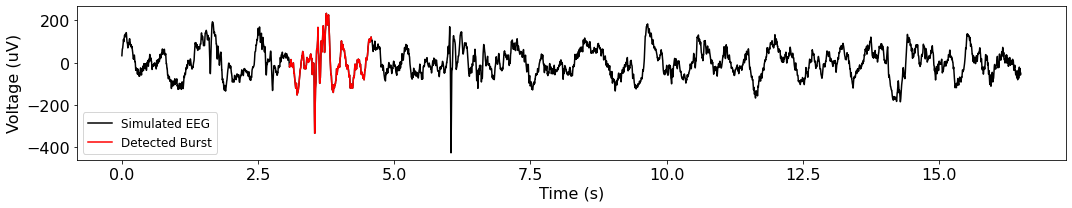

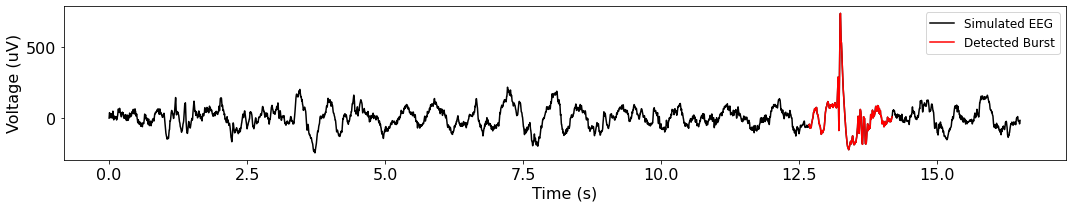

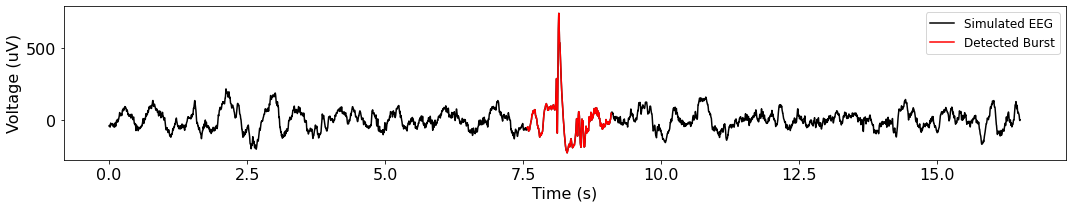

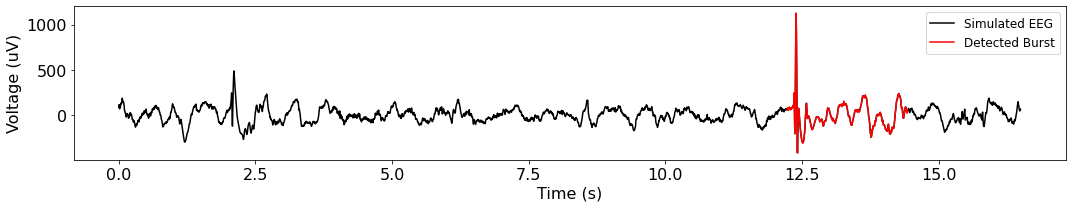

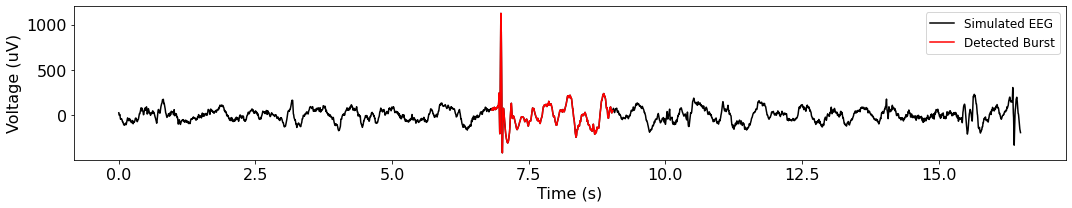

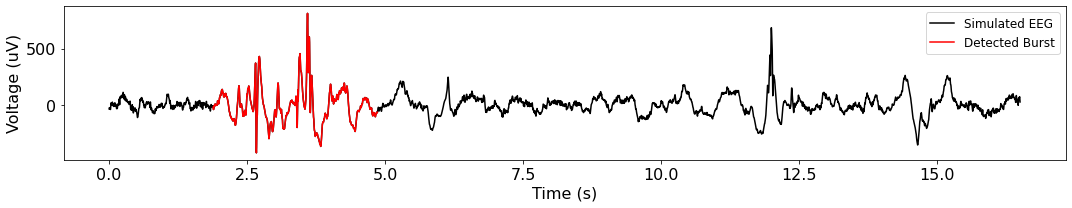

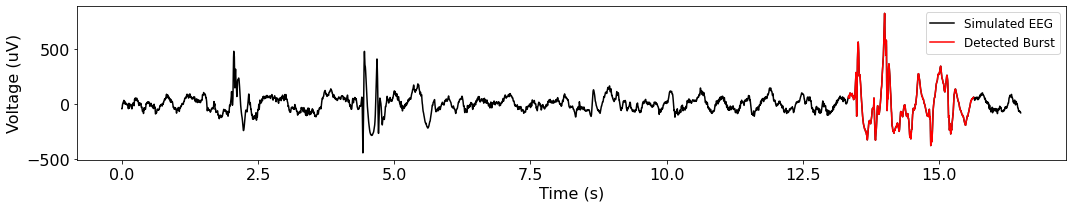

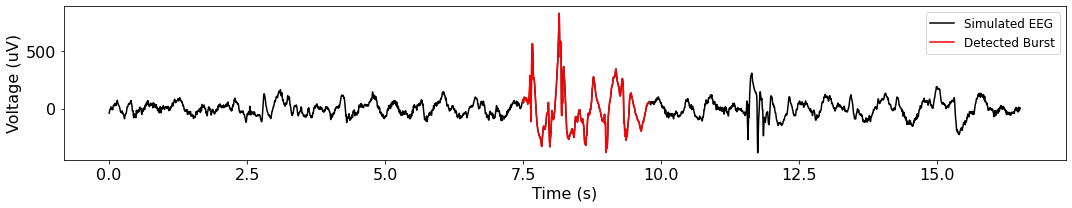

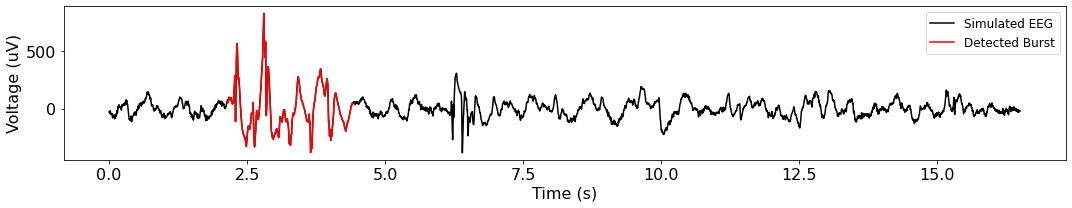

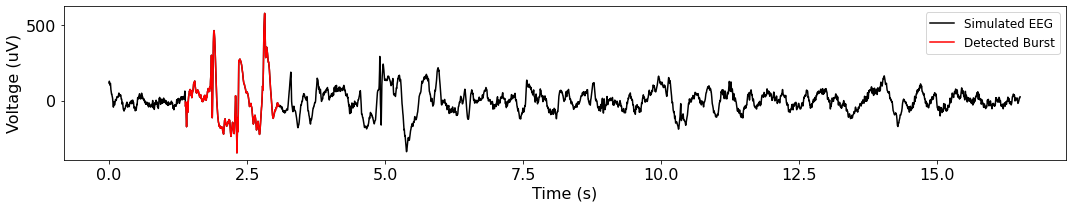

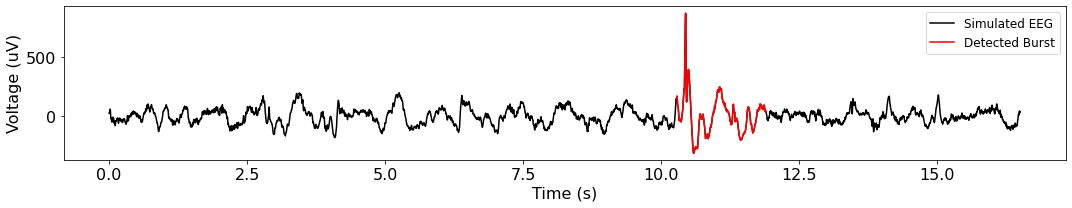

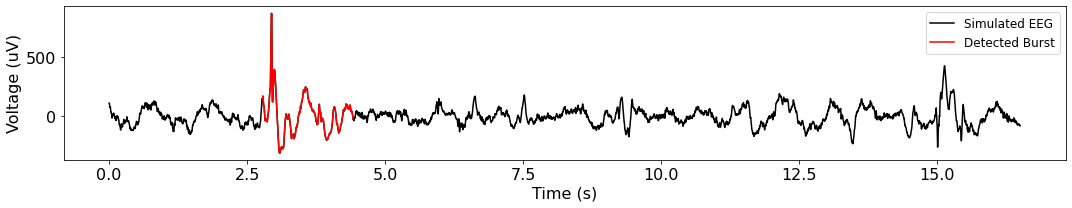

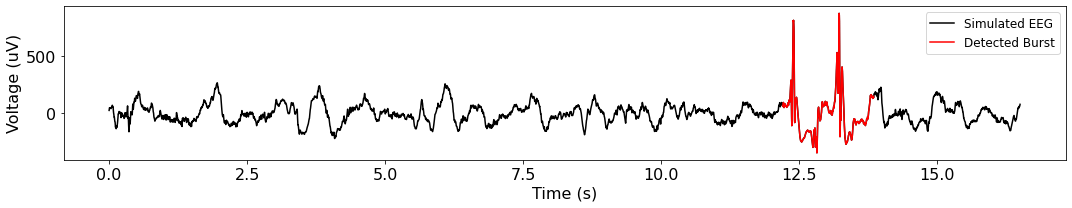

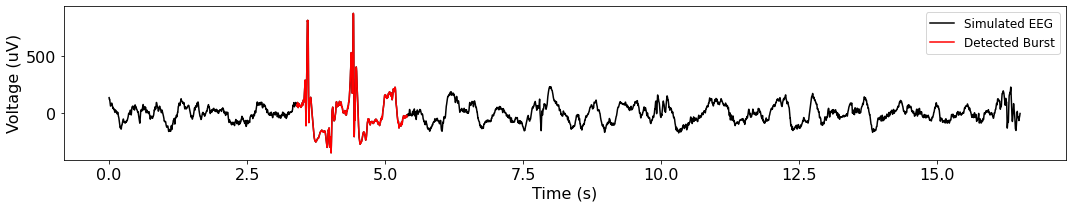

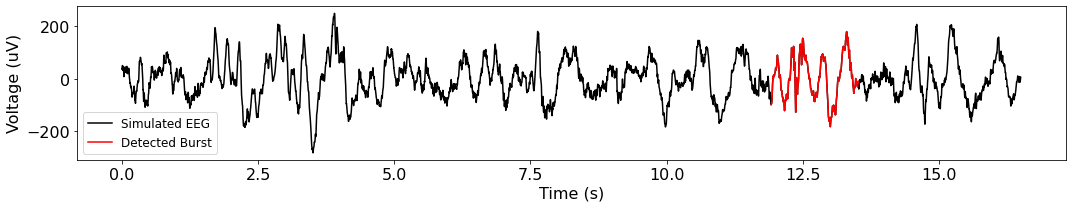

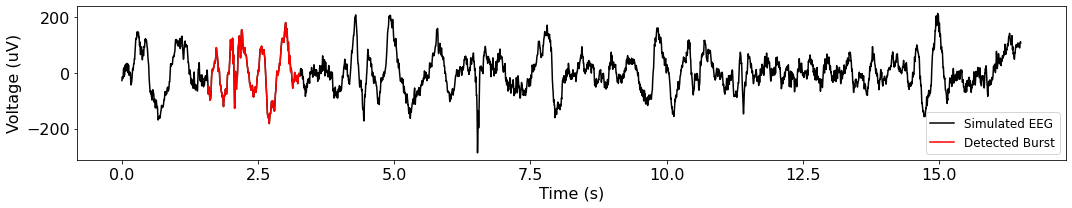

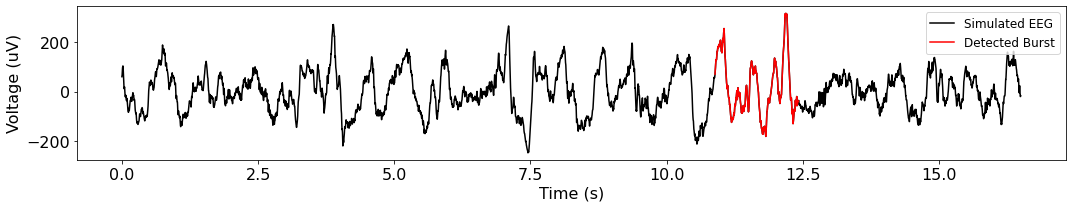

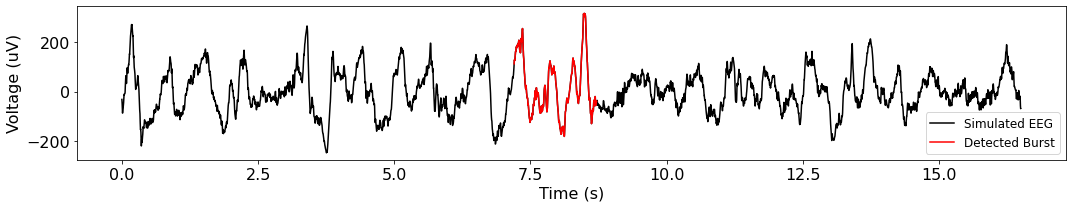

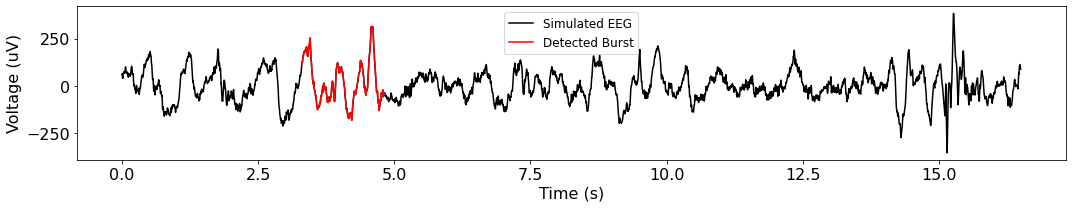

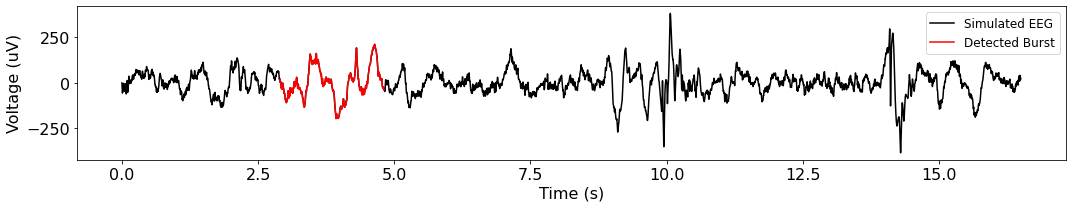

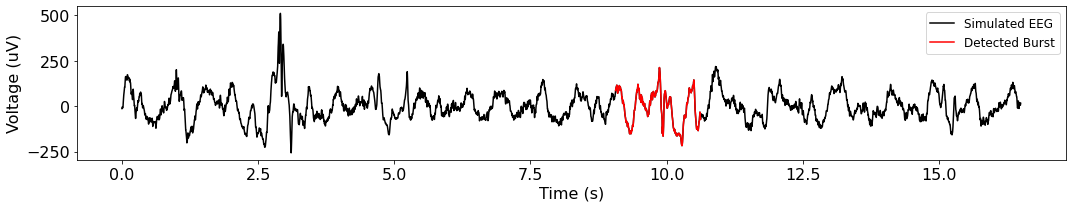

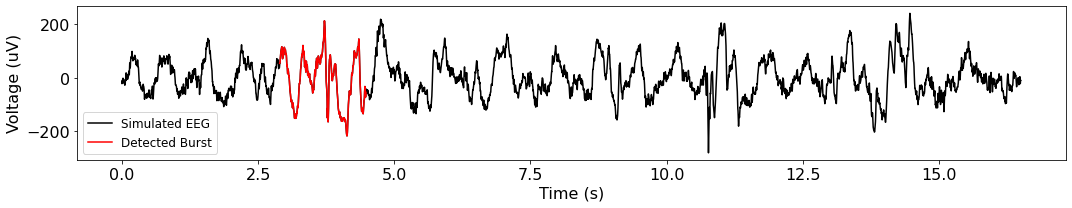

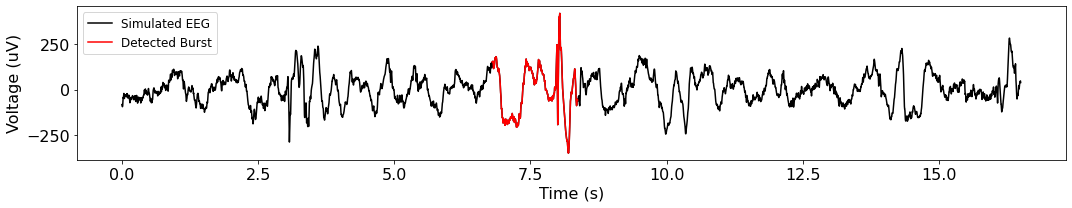

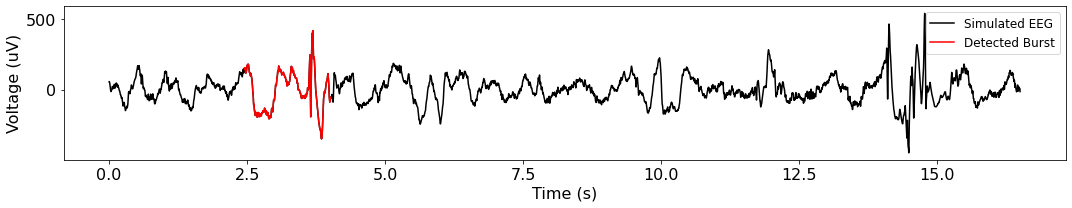

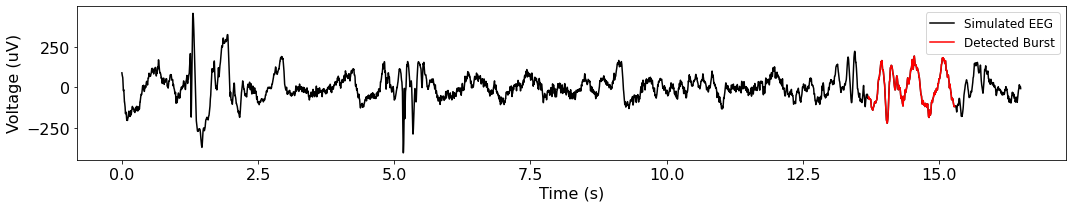

In [15]:
# set up freq bands
fs = 2000
amp_dual_thresh = (1, 2)
f_range = (2, 6)
ch = 'HL5-HL6'
times = create_times(16.5005, fs)

chx = epoched_data.info['ch_names'].index(ch)

burst_list = []
for trial in range(epoch_df.shape[0]): # iterate over trials
    # get single trial
    sig = epoch_df[trial, chx, :]
    # Detect bursts using dual threshold algorithm
    bursting = detect_bursts_dual_threshold(sig, fs, amp_dual_thresh, f_range)
    
    if np.any(bursting):
        plot_bursts(times, sig, bursting, labels=['Simulated EEG', 'Detected Burst'])

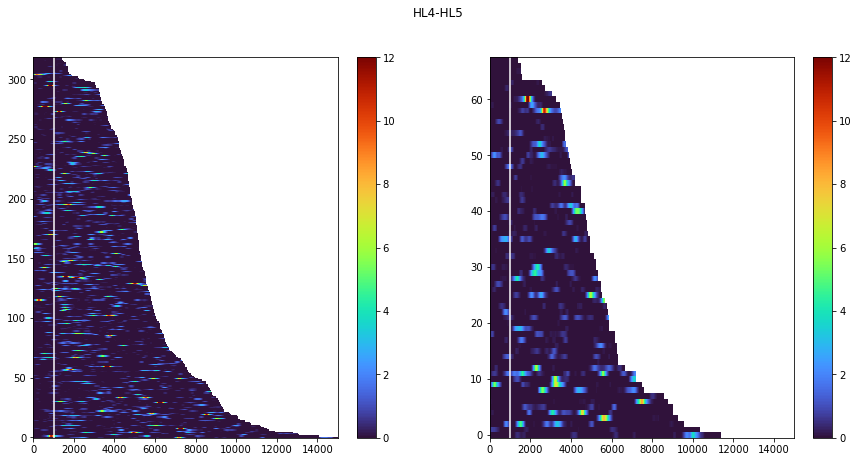

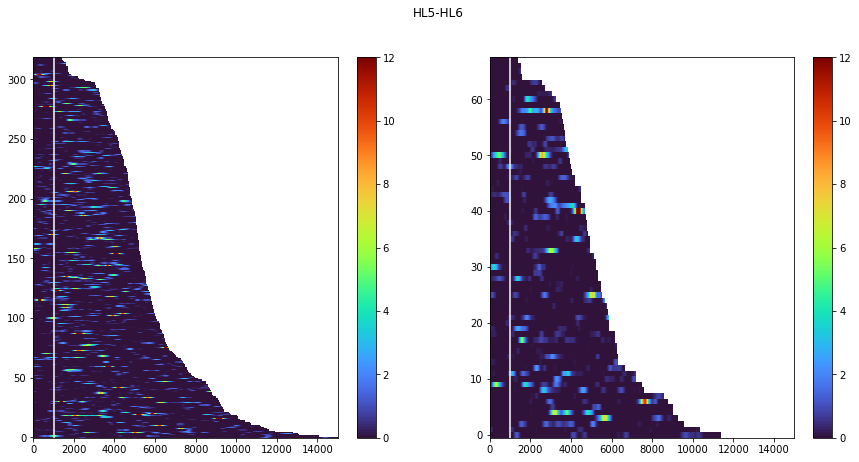

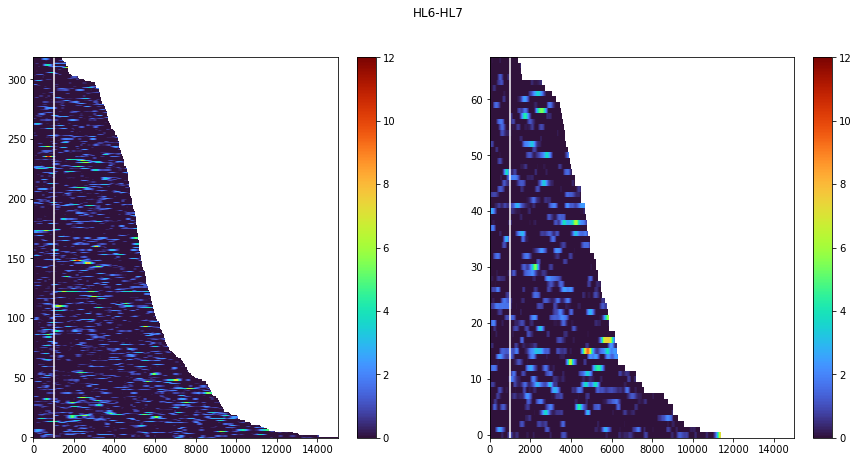

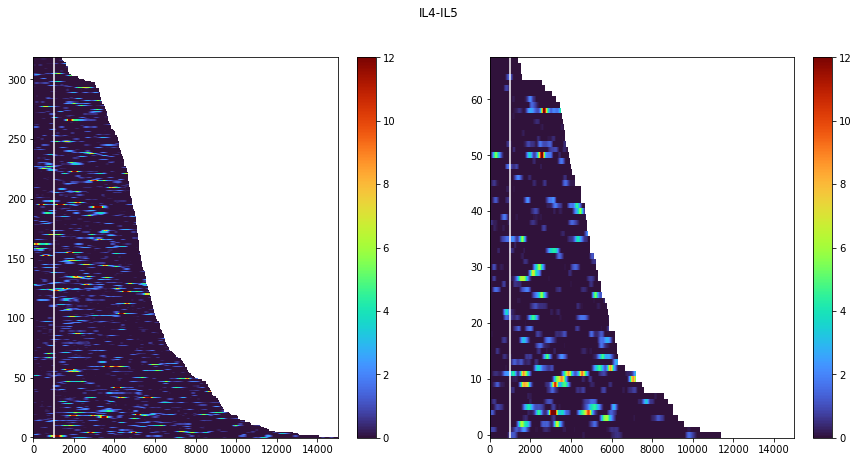

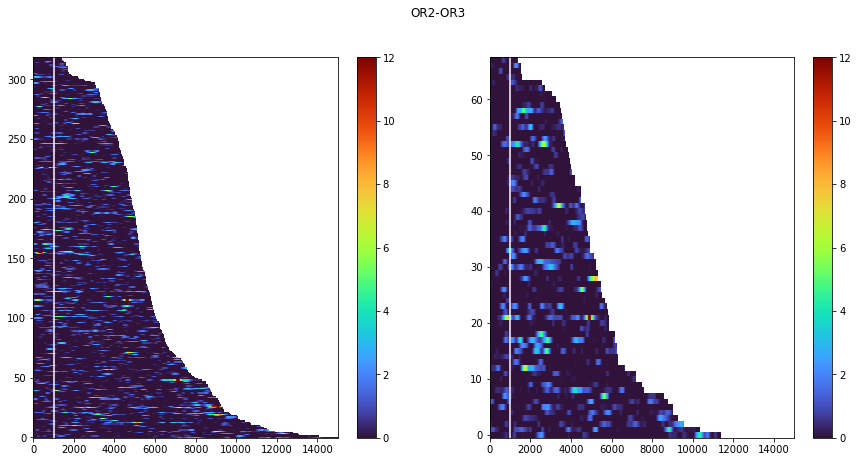

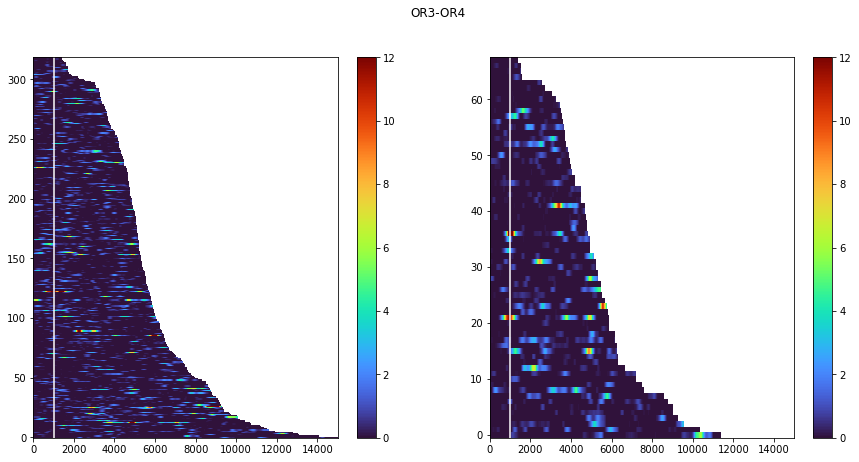

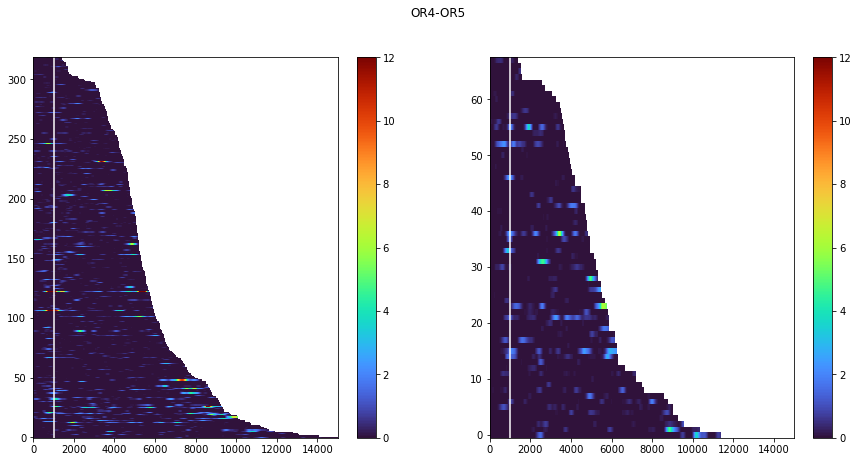

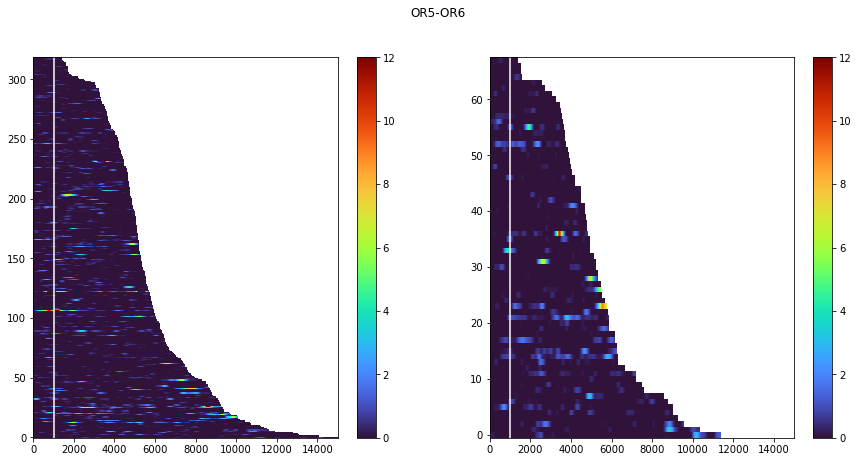

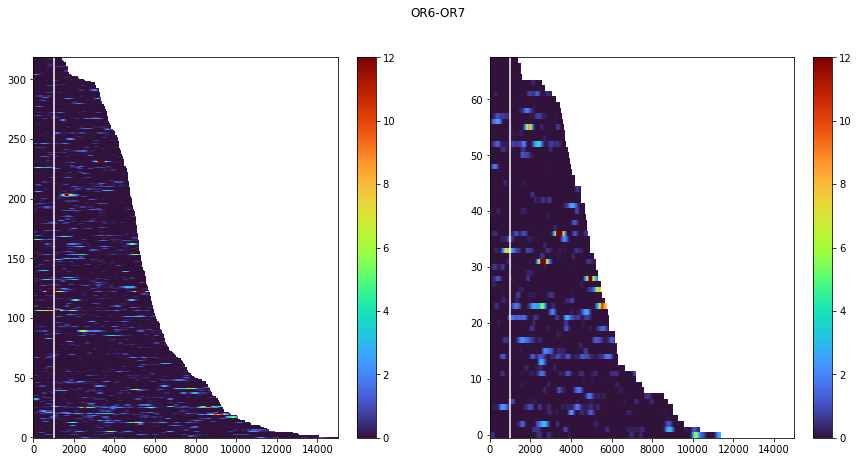

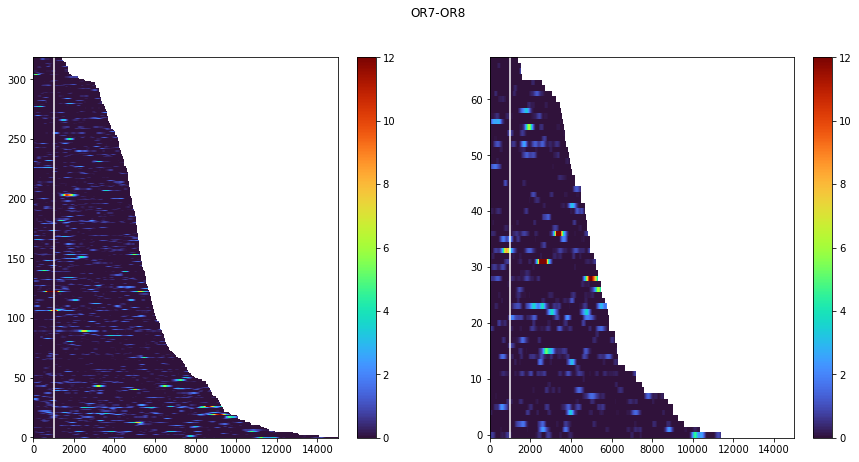

In [95]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

### plot theta by no ghost and ghost trials

# set up freq bands
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
ch = 'HL4-HL5'

# get the indices of no ghost trials
clean_behave_data.reset_index(inplace=True, drop = True)
no_ghost_trials = clean_behave_data.index[clean_behave_data['TrialType'] > 16].tolist()
ghost_trials = clean_behave_data.index[clean_behave_data['TrialType'] <= 16].tolist()

# sort the trial lengths
longest_idx = np.flip(np.argsort(usable_trial_lengths))

# Get trial type specific trial lengths
ghost_trial_lengths = np.delete(longest_idx, no_ghost_trials)
no_ghost_trial_lengths = np.delete(longest_idx, ghost_trials)


for ch in hc_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []

    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 2000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, int(le):na_end] = np.nan
        
    # baseline the data
    baselined_average_mwts = baseline_wavelets(tmin = 500, tmax = 1000, average_mwts = average_mwts)

    # sort by longest trial
    ba_average_ghost_mwts = baselined_average_mwts[ghost_trial_lengths, :]
    ba_average_no_ghost_mwts = baselined_average_mwts[no_ghost_trial_lengths, :]

    #plot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    left = ax1.pcolormesh(np.arange(baselined_average_mwts.shape[1]), np.arange(len(ghost_trial_lengths)), ba_average_ghost_mwts, cmap = 'turbo', vmin = 0, vmax = 12)
    right = ax2.pcolormesh(np.arange(baselined_average_mwts.shape[1]), np.arange(len(no_ghost_trial_lengths)), ba_average_no_ghost_mwts, cmap = 'turbo', vmin = 0, vmax = 12)
    ax1.axvline(x=1000, color = 'white')
    ax2.axvline(x=1000, color = 'white')
    fig.colorbar(left, ax=ax1)
    fig.colorbar(right, ax=ax2)
    fig.suptitle(ch)
    plt.show()
    

In [97]:
clean_behave_data



subject  Trial  trial_numeric  trial_in_block  TrialType  trial_died  \
0    BJH016      0              2               2          8           1   
1    BJH016      1              3               3         11           1   
2    BJH016      2              4               4          3           0   
3    BJH016      3              5               5         10           1   
4    BJH016      4              6               6         15           1   
..      ...    ...            ...             ...        ...         ...   
380  BJH016    446            448               8         18           0   
381  BJH016    447            449               9         19           1   
382  BJH016    448            450              10         13           1   
383  BJH016    449            451              11          5           0   
384  BJH016    450            452              12          1           0   

     last_trial_in_minigame  Lives  dots_eaten  max_trial  ...  average_score  \
0                         0      3           5        452  ...     321.177458   
1                         0      2           5        452  ...     321.177458   
2                         0      1           0        452  ...     321.177458   
3                         1      1           5        452  ...     321.177458   
4                         0      3           4        452  ...     321.177458   
..                      ...    ...         ...        ...  ...            ...   
380                       0      1           5        452  ...     321.177458   
381                       1      1           5        452  ...     321.177458   
382                       0      3           5        452  ...     321.177458   
383                       0      2           0        452  ...     321.177458   
384                       0      1           0        452  ...     321.177458   

     max_time  trial_in_minigame  minigame  longest_minigame  \
0     2937.75                  2         1                19   
1     2937.75                  3         1                19   
2     2937.75                  4         1                19   
3     2937.75                  5         1                19   
4     2937.75                  1         2                19   
..        ...                ...       ...               ...   
380   2937.75                  8        64                19   
381   2937.75                  9        64                19   
382   2937.75                  1        65                19   
383   2937.75                  2        65                19   
384   2937.75                  3        65                19   

     longest_minigame_under20  number_of_minigames  block  block_deaths  \
0                          19                   65      1            14   
1                          19                   65      1            14   
2                          19                   65      1            14   
3                          19                   65      1            14   
4                          19                   65      1            14   
..                        ...                  ...    ...           ...   
380                        19                   65     23             3   
381                        19                   65     23             3   
382                        19                   65     23             3   
383                        19                   65     23             3   
384                        19                   65     23             3   

     average_dots_per_block  
0                      3.35  
1                      3.35  
2                      3.35  
3                      3.35  
4                      3.35  
..                      ...  
380                    3.75  
381                    3.75  
382                    3.75  
383                    3.75  
384                    3.75  

[385 rows x 21 columns]

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

### plot theta by no ghost and ghost trials

# set up freq bands
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
ch = 'HL4-HL5'

# get the indices of no ghost trials
clean_behave_data.reset_index(inplace=True, drop = True)
no_ghost_trials = clean_behave_data.index[clean_behave_data['TrialType'] > 16].tolist()
ghost_trials = clean_behave_data.index[clean_behave_data['TrialType'] <= 16].tolist()

# sort the trial lengths
longest_idx = np.flip(np.argsort(usable_trial_lengths))

# Get trial type specific trial lengths
ghost_trial_lengths = np.delete(longest_idx, no_ghost_trials)
no_ghost_trial_lengths = np.delete(longest_idx, ghost_trials)


for ch in hc_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []

    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 2000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, int(le):na_end] = np.nan
        
    # baseline the data
    baselined_average_mwts = baseline_wavelets(tmin = 500, tmax = 1000, average_mwts = average_mwts)

    # sort by longest trial
    ba_average_ghost_mwts = baselined_average_mwts[ghost_trial_lengths, :]
    ba_average_no_ghost_mwts = baselined_average_mwts[no_ghost_trial_lengths, :]

    #plot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    left = ax1.pcolormesh(np.arange(baselined_average_mwts.shape[1]), np.arange(len(ghost_trial_lengths)), ba_average_ghost_mwts, cmap = 'turbo', vmin = 0, vmax = 12)
    right = ax2.pcolormesh(np.arange(baselined_average_mwts.shape[1]), np.arange(len(no_ghost_trial_lengths)), ba_average_no_ghost_mwts, cmap = 'turbo', vmin = 0, vmax = 12)
    ax1.axvline(x=1000, color = 'white')
    ax2.axvline(x=1000, color = 'white')
    fig.colorbar(left, ax=ax1)
    fig.colorbar(right, ax=ax2)
    fig.suptitle(ch)
    plt.show()
    

### Amygdala

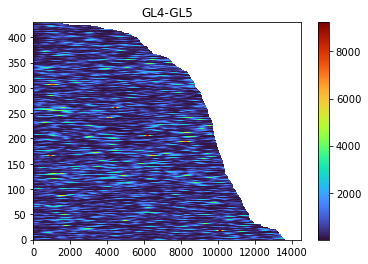

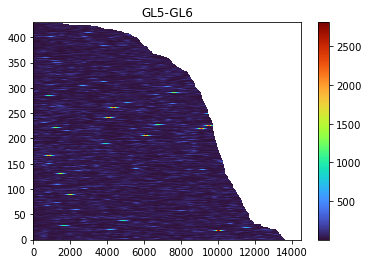

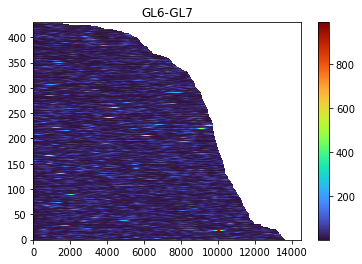

In [53]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in amyg_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    
    

### OFC

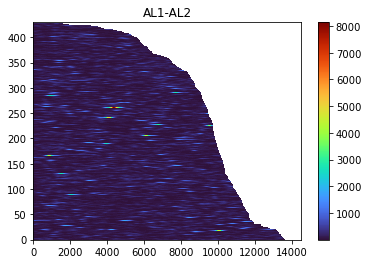

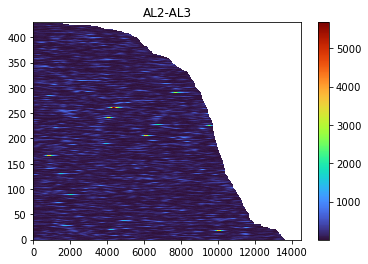

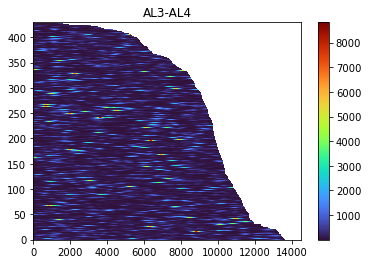

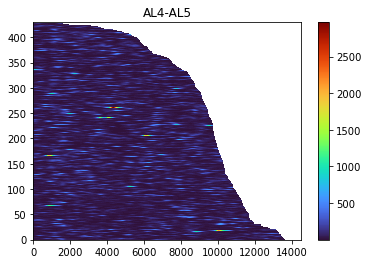

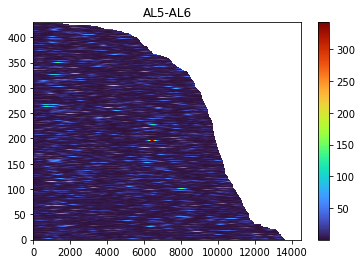

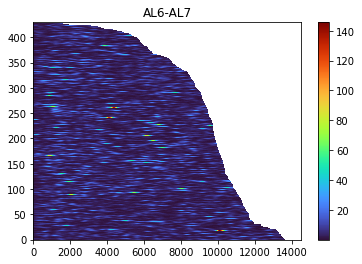

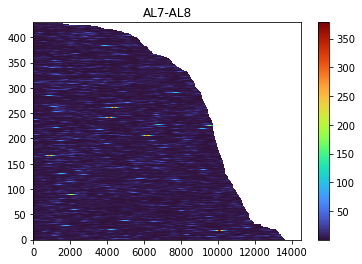

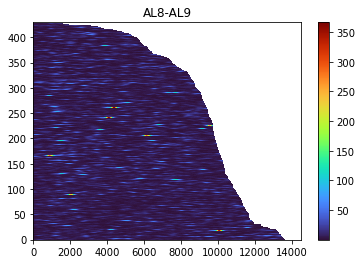

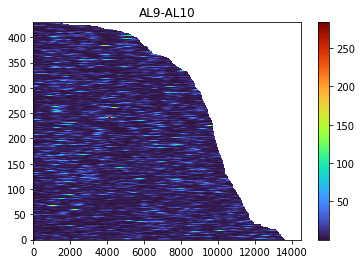

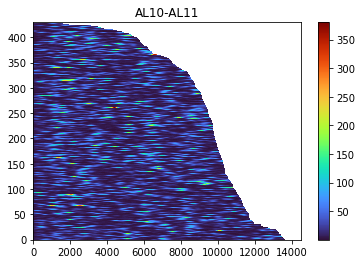

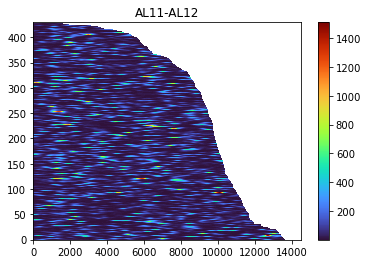

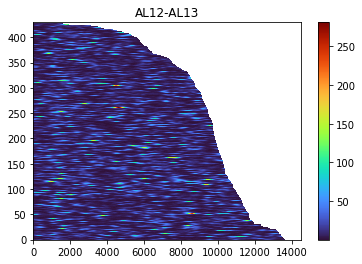

In [54]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in ofc_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    

### Insula

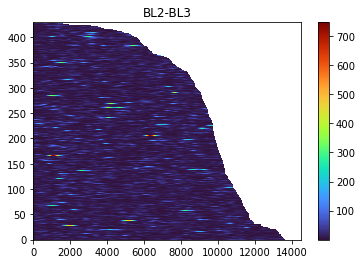

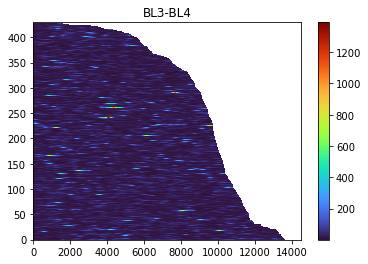

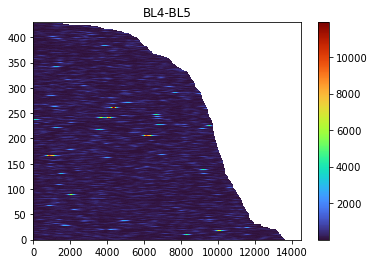

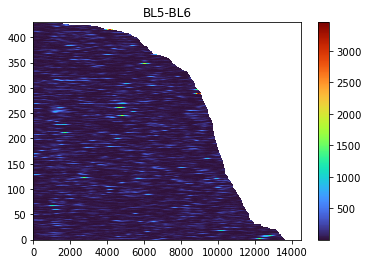

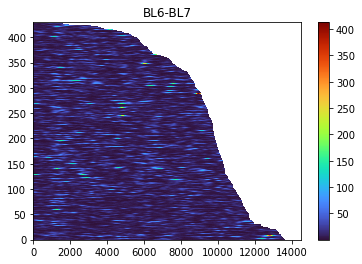

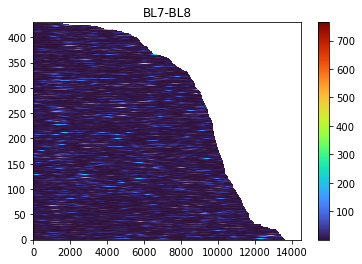

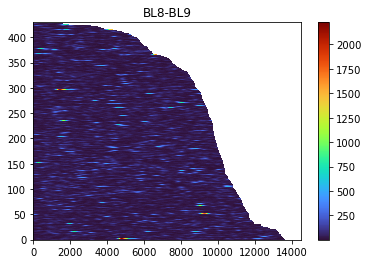

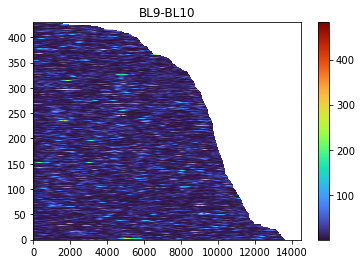

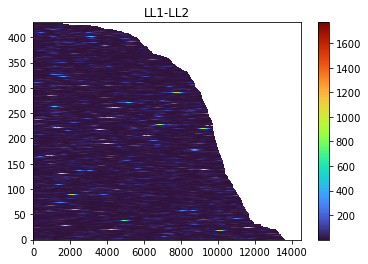

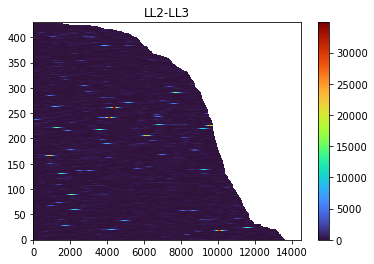

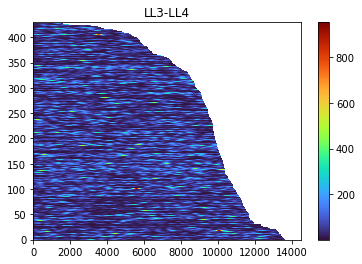

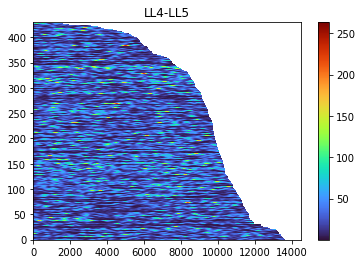

In [55]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in insula_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    

### Anterior Cingulate

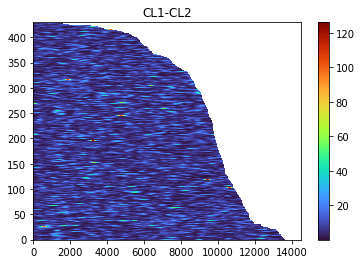

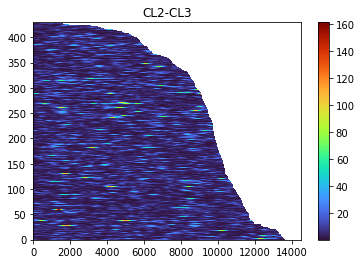

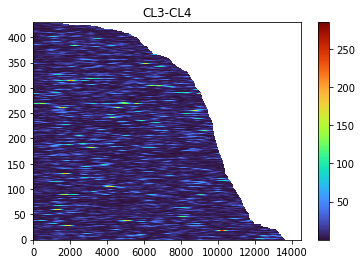

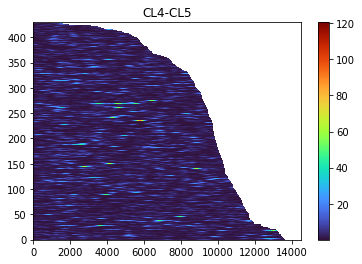

In [56]:
%matplotlib inline

# ch = epoched_data.info['ch_names'].index('HL3-HL4')
fs = 2000
freq_range = np.logspace(0.5, .9, num=5)
longest_idx = np.argsort(usable_trial_lengths)

for ch in cing_list:
    chx = epoched_data.info['ch_names'].index(ch)
    mwts = []
    
    for trial in range(epoch_df.shape[0]): # iterate over trials
        sig = epoch_df[trial, chx, :]
        downsamp = signal.decimate(sig, 2) # get down from 5 khz sampling to 1 khz
        mwt = wavelet_transform(downsamp, fs/2, freq_range, pad_amount=1.5)
        mwts.append(mwt)

    #phases = np.array([np.angle(X) for X in mwts])
    mwts = np.array([np.abs(X)**2 for X in mwts]) # get power

    # average theta frequencies
    average_mwts = np.mean(mwts, axis = 1)

    # nan out after trial events
    na_end = average_mwts.shape[1]
    for idx in range(average_mwts.shape[0]):
        le = np.floor((usable_trial_lengths[idx] + 1000)/2)
        na_begin = int(na_end - le)
        average_mwts[idx, na_begin:na_end] = np.nan

    # sort by longest trial
    average_mwts = average_mwts[longest_idx, :]

    #plot
    # plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo', vmin = 0, vmax = 30000)
    plt.pcolormesh(np.arange(14501), np.arange(430), average_mwts, cmap = 'turbo')
    plt.colorbar()
    plt.title(ch)
    plt.show()
    